In [1]:
!pip install transformers
!pip install sentencepiece

In [2]:
# Importing the libraries needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, RandomSampler, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import logging
logging.basicConfig(level=logging.ERROR)

In [3]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, AutoModel
import re

In [4]:
from transformers import BertTokenizer, BertForSequenceClassification
import sklearn

In [5]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
#You may replaced "Twitter/twhin-bert-base" with 'ai4bharat/indic-bert',
#("jhu-clsp/bernice", model_max_length=128),
#"google/muril-base-cased","xlm-roberta-base"
#or any other
tokenizer = AutoTokenizer.from_pretrained("Twitter/twhin-bert-base")

In [7]:
#choose appropriate model
model = BertForSequenceClassification.from_pretrained('Twitter/twhin-bert-base',
                                                      num_labels=3)
model.to(device)

Some weights of the model checkpoint at Twitter/twhin-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Twitter/twhin-bert-ba

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(250002, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
              (distance_embedding): Embedding(1023, 64)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
      

In [8]:
import random
seed_val=3407
torch.manual_seed(seed_val)
np.random.seed(seed_val)
random.seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Load LIC IPO data

In [9]:
# Load LIC_IPO dataset
df_train = pd.read_csv("/kaggle/input/ipolic/IPO_WholeDataset_ClassCreate (1).csv",
                       names = ["tweet", "classes"])
df_train = df_train.iloc[1: , :]
df_train['IPO_name'] = 'LIC'
df_train.head()

,tweet,classes,IPO_name
1,Millions of Indians investing in the country’s...,0.0,LIC
2,టోకు ద్రవ్యోల్బణమే కీలకం via తాజా వార్తలు | ...,1.0,LIC
3,મેરે રે કો એસે ધક ધક હો રહા હે....\nfingers cr...,1.0,LIC
4,The country's largest insurer will list itself...,1.0,LIC
5,Can a full time employee ask for board of dire...,1.0,LIC


In [10]:
from sklearn.preprocessing import LabelEncoder

#Load the encoder
LE = LabelEncoder()

In [11]:
df_train['classes'] = LE.fit_transform(df_train['classes'])
df_train.head()

,tweet,classes,IPO_name
1,Millions of Indians investing in the country’s...,0,LIC
2,టోకు ద్రవ్యోల్బణమే కీలకం via తాజా వార్తలు | ...,1,LIC
3,મેરે રે કો એસે ધક ધક હો રહા હે....\nfingers cr...,1,LIC
4,The country's largest insurer will list itself...,1,LIC
5,Can a full time employee ask for board of dire...,1,LIC


In [12]:
#import scipy.stats as stats
table = df_train.classes.value_counts()/df_train.classes.count()
print(table)

1    0.684375
0    0.238542
2    0.077083
Name: classes, dtype: float64


### Load Zomato IPO data

Zomato IPO data is taken from kaggle
https://www.kaggle.com/datasets/komalkhetlani/tweets-about-zomatoipo

In [13]:
zomato = pd.read_csv('/kaggle/input/zomatoipo/zomato_IPO.csv',names = ["tweet", "classes"])
zomato = zomato.iloc[1:,:]
zomato['IPO_name'] = 'zomato'
zomato.head()

,tweet,classes,IPO_name
0.0,"@ipo_mantra I haven't applied for Zomato IPO ,...",1,zomato
1.0,#PaytmIPO #PaytmIPOnews #zomatoipo #Zomatoshar...,2,zomato
2.0,#wipro CMP 570😍 Trgt achieved 🚀😉 (Safe players...,1,zomato
3.0,So much love poured by the startup community o...,2,zomato
4.0,Zomato IPO: India food delivery 'unicorn' open...,1,zomato


In [14]:
zomato['classes'] = LE.fit_transform(zomato['classes'])
zomato.head()

,tweet,classes,IPO_name
0.0,"@ipo_mantra I haven't applied for Zomato IPO ,...",1,zomato
1.0,#PaytmIPO #PaytmIPOnews #zomatoipo #Zomatoshar...,2,zomato
2.0,#wipro CMP 570😍 Trgt achieved 🚀😉 (Safe players...,1,zomato
3.0,So much love poured by the startup community o...,2,zomato
4.0,Zomato IPO: India food delivery 'unicorn' open...,1,zomato


In [15]:
#concatenate both data sets
data = pd.concat([df_train,zomato])
data.shape

(12454, 3)

In [16]:
#Label encoding for the IPO_name
data['IPO_name'] = LE.fit_transform(data['IPO_name'])
data.head()

,tweet,classes,IPO_name
1.0,Millions of Indians investing in the country’s...,0,0
2.0,టోకు ద్రవ్యోల్బణమే కీలకం via తాజా వార్తలు | ...,1,0
3.0,મેરે રે કો એસે ધક ધક હો રહા હે....\nfingers cr...,1,0
4.0,The country's largest insurer will list itself...,1,0
5.0,Can a full time employee ask for board of dire...,1,0


In [17]:
data.describe()

,classes,IPO_name
count,12454.000000,12454.000000
mean,1.268107,0.922916
std,0.647797,0.266735
min,0.000000,0.000000
25%,1.000000,1.000000
50%,1.000000,1.000000
75%,2.000000,1.000000
max,2.000000,1.000000


### Save the dataset for future use!!

In [18]:
#data.to_csv('IPO_LICZomato.csv',index=False)

### Useful Insights from the data


In [19]:
data.classes.unique()

array([0, 1, 2])

In [20]:
data.IPO_name.unique()

array([0, 1])

In [21]:
table = data.classes.value_counts()/data.classes.count()
print(table)

1    0.508511
2    0.379798
0    0.111691
Name: classes, dtype: float64


In [22]:
table = data.IPO_name.value_counts()/data.IPO_name.count()
print(table)

1    0.922916
0    0.077084
Name: IPO_name, dtype: float64


In [23]:
#maximum length of the tweet
max_len = 0
num_tokens = 0

# For every sentence...
for sent in data.tweet:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    num_tokens += (len(input_ids)-2)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)
print('The number of tokens: ', num_tokens)

Max sentence length:  145
The number of tokens:  532599


In [24]:
from sklearn.model_selection import train_test_split

#split original DataFrame into training and testing sets
train, test_data = train_test_split(data, test_size=0.2, random_state=seed_val)
train_data, val_data = train_test_split(train, test_size=0.1, random_state=seed_val)

In [25]:
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (8966, 3)
Validation data shape: (997, 3)
Test data shape: (2491, 3)


In [26]:
table = train.IPO_name.value_counts()/train.IPO_name.count()
print(table)

1    0.92161
0    0.07839
Name: IPO_name, dtype: float64


In [27]:
'''
train_size = 0.8
train_data=data.sample(frac=train_size,random_state=seed_val)
test_data=data.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(data.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))
'''

'\ntrain_size = 0.8\ntrain_data=data.sample(frac=train_size,random_state=seed_val)\ntest_data=data.drop(train_data.index).reset_index(drop=True)\ntrain_data = train_data.reset_index(drop=True)\n\nprint("FULL Dataset: {}".format(data.shape))\nprint("TRAIN Dataset: {}".format(train_data.shape))\nprint("TEST Dataset: {}".format(test_data.shape))\n'

In [28]:
# Defining some key variables that will be used later on in the training
MAX_LEN = 145
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 4

In [29]:
class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.tweet.to_list()
        self.targets = dataframe.classes.to_list()
        self.IPO_name = dataframe.IPO_name.to_list()
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index]) 
        text = " ".join(text.split())
        targets = self.targets[index]
        IPO_name = self.IPO_name[index]
        inputs = self.tokenizer.encode_plus(text,add_special_tokens=True,
                                            max_length=self.max_len,
                                            pad_to_max_length=True,
                                            return_token_type_ids=True,
                                            return_attention_mask=True)
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        return {'ids': torch.tensor(ids, dtype=torch.long),
                'mask': torch.tensor(mask, dtype=torch.long),
                'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
                'targets': torch.tensor(targets, dtype=torch.float),
                'IPO_name': torch.tensor(IPO_name, dtype=torch.float)
               }

In [30]:
#create Sentiment Dataset
train_data_sent = SentimentData(train_data, tokenizer, MAX_LEN)
val_data_sent = SentimentData(val_data, tokenizer, MAX_LEN)
test_data_sent = SentimentData(test_data, tokenizer, MAX_LEN)

In [31]:
next(iter(train_data_sent),1)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


{'ids': tensor([     0,   5659,  71516,    100,    468,  60551,  39499, 102402,     87,
            444,   4382,  65321,   9077,     87,    444,    959,   7730,     47,
           2046,    442,      5,      2,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,     

In [32]:
# testing chunk for next(iter(train_data),1)
'''
ids= next(iter(train_data),1)['ids'].to(device, dtype = torch.long)
mask = next(iter(train_data),1)['mask'].to(device, dtype = torch.long)
tokens = next(iter(train_data),1)['token_type_ids'].to(device, dtype = torch.long)
print(mask)
'''

"\nids= next(iter(train_data),1)['ids'].to(device, dtype = torch.long)\nmask = next(iter(train_data),1)['mask'].to(device, dtype = torch.long)\ntokens = next(iter(train_data),1)['token_type_ids'].to(device, dtype = torch.long)\nprint(mask)\n"

In [33]:
train_loader= DataLoader(train_data_sent,batch_size=TRAIN_BATCH_SIZE,shuffle=True)#sampler = RandomSampler(train_data_sent),
val_loader= DataLoader(val_data_sent, batch_size=TRAIN_BATCH_SIZE,shuffle=True)#,sampler = RandomSampler(val_data_sent),
test_loader = DataLoader(test_data_sent, batch_size=VALID_BATCH_SIZE)

In [34]:
next(iter(train_loader),1)

{'ids': tensor([[     0,   1374,    434,  ...,      1,      1,      1],
         [     0,  16934,     12,  ...,      1,      1,      1],
         [     0, 113307,  40514,  ...,      1,      1,      1],
         ...,
         [     0,   5880,  39499,  ...,      1,      1,      1],
         [     0,  11205,  37397,  ...,      1,      1,      1],
         [     0,    468,  60551,  ...,      1,      1,      1]]),
 'mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]),
 'targets': tensor([1., 1., 2., 1., 2., 1., 1., 2., 1., 0., 1., 1., 2., 1., 0., 1., 1., 2.,
         2., 1., 

In [35]:
#named parameters in the model
#for a in model.named_modules():
#    print(a)

In [36]:
'''
weights = [.762, .316, .923]
class_weights=torch.tensor(weights,dtype=torch.float)
loss_function = torch.nn.CrossEntropyLoss(weight = class_weights)
#loss_function = torch.nn.CrossEntropyLoss()#weight = class_weights
'''

'\nweights = [.762, .316, .923]\nclass_weights=torch.tensor(weights,dtype=torch.float)\nloss_function = torch.nn.CrossEntropyLoss(weight = class_weights)\n#loss_function = torch.nn.CrossEntropyLoss()#weight = class_weights\n'

In [37]:
#!pip install pytorch-optimizer

In [38]:
from transformers import AdamW
optimizer = AdamW(model.parameters(),lr = 5e-5, eps = 1e-8)
# args.learning_rate - default is 5e-5, our notebook had 2e-5
# args.adam_epsilon  - default is 1e-8.

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [39]:
from transformers import get_linear_schedule_with_warmup

epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_loader) * epochs
print(total_steps)

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

1124


In [40]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    acc = np.sum(pred_flat == labels_flat) / len(labels_flat)
    #cnf_mat = sklearn.metrics.confusion_matrix(labels_flat,pred_flat)
    return acc

In [41]:
def train_classifier(model,train_loader,val_loader,optimizer,epochs=4):
    print("Training...")
    training_stats = []
    for epoch in range(epochs):
        total_train_loss = 0
        total_train_acc = 0
        model.train()
        #load the batch
        for step, batch in tqdm(enumerate(train_loader,0)):#enumerate(train_loader)
            input_ids = batch['ids'].to(device, dtype = torch.long)
            input_mask = batch['mask'].to(device, dtype = torch.long)
            input_token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            input_targets = batch['targets'].to(device, dtype = torch.long)
            #outputs = model(ids, mask, token_type_ids).squeeze()
            #loss = loss_function(outputs, targets)
            
            optimizer.zero_grad()
            outputs = model(input_ids, token_type_ids=None,attention_mask=input_mask,
                             labels=input_targets)
            loss = outputs.loss
            total_train_loss += loss.item()
            logits = outputs.logits
            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = input_targets.to('cpu').numpy()
            total_train_acc += flat_accuracy(logits, label_ids)
            loss.backward()
            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            optimizer.step()
            # Update the learning rate.
            scheduler.step()
        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Average training loss: {avg_train_loss: 0.2f}")
        avg_train_acc = total_train_acc / len(train_loader)
        print(f"The training accuracy for the epoch {epoch} is {avg_train_acc}")

        print("*****")
        print("Validation...!!")
        model.eval()
        # Tracking variables 
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0
        # Evaluate data for one epoch
        for _,batch in tqdm(enumerate(val_loader,0)):
            val_ids = batch['ids'].to(device, dtype = torch.long)
            val_mask = batch['mask'].to(device, dtype = torch.long)
            val_token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
            val_targets = batch['targets'].to(device, dtype = torch.long)
            with torch.no_grad(): 
                val_out = model(val_ids,token_type_ids=None,
                                attention_mask=val_mask,labels=val_targets)
                loss = val_out.loss
                logits = val_out.logits
                # Accumulate the validation loss.
                total_eval_loss += loss.item()

                # Move logits and labels to CPU
                logits = logits.detach().cpu().numpy()
                label_ids = val_targets.to('cpu').numpy()
                total_eval_accuracy += flat_accuracy(logits, label_ids) 

        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(val_loader)
        print("Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(val_loader)

        print("Validation Loss: {0:.2f}".format(avg_val_loss))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                "Train. Accur.": avg_train_acc,
                'Valid. Accur.': avg_val_accuracy
            })            
    print("Training Complete!!")
    return training_stats

In [42]:
#train the model and collect the statistics
stats = train_classifier(model,train_loader,val_loader,optimizer)

Training...


281it [02:09,  2.17it/s]


Average training loss:  0.59
The training accuracy for the epoch 0 is 0.7603054567022539
*****
Validation...!!


32it [00:04,  7.04it/s]


Accuracy: 0.84
Validation Loss: 0.39


281it [02:08,  2.19it/s]


Average training loss:  0.29
The training accuracy for the epoch 1 is 0.8984282325029657
*****
Validation...!!


32it [00:04,  6.99it/s]


Accuracy: 0.89
Validation Loss: 0.32


281it [02:08,  2.19it/s]


Average training loss:  0.15
The training accuracy for the epoch 2 is 0.9489546263345195
*****
Validation...!!


32it [00:04,  7.01it/s]


Accuracy: 0.90
Validation Loss: 0.31


281it [02:08,  2.19it/s]


Average training loss:  0.08
The training accuracy for the epoch 3 is 0.9733096085409253
*****
Validation...!!


32it [00:04,  6.91it/s]

Accuracy: 0.90
Validation Loss: 0.41
Training Complete!!


In [43]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Train. Accur.,Valid. Accur.
epoch,,,,
1,0.59,0.39,0.76,0.84
2,0.29,0.32,0.90,0.89
3,0.15,0.31,0.95,0.90
4,0.08,0.41,0.97,0.90


## Evalution of the model

### Performance on entire data

In [44]:
#eval function
def eval_model(model,loader):
    print("Evaluation...!!")
    model.eval()
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0
    preds = []
    labels = []
    IPO_label = []
    # Evaluate data for one epoch
    for _,batch in tqdm(enumerate(loader,0)):
        val_ids = batch['ids'].to(device, dtype = torch.long)
        val_mask = batch['mask'].to(device, dtype = torch.long)
        val_token_type_ids = batch['token_type_ids'].to(device, dtype=torch.long)
        val_targets = batch['targets'].to(device, dtype = torch.long)
        IPO_name = batch['IPO_name'].to(device, dtype = torch.long)
        with torch.no_grad(): 
            val_out = model(val_ids,token_type_ids=None,
                                attention_mask=val_mask,labels=val_targets)
            loss = val_out.loss
            logits = val_out.logits
            # Accumulate the validation loss.
            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = val_targets.to('cpu').numpy()
            total_eval_accuracy += flat_accuracy(logits, label_ids) 
            preds.extend(np.argmax(logits, axis=1).flatten())
            labels.extend(label_ids.flatten())
            IPO_label.extend(IPO_name.detach().cpu().numpy().flatten())

        # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(loader)
    print("Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(loader)

    print("Test Loss: {0:.2f}".format(avg_val_loss))
    df = pd.DataFrame({'labels': labels, 'Preds': preds, 'IPO_label':IPO_label}) 
    print("Evaluation Complete!!")
    return df

In [45]:
#evaluate the model and collect the outputs, labels and IPO_label
df = eval_model(model, test_loader)

Evaluation...!!


0it [00:00, ?it/s]/opt/conda/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2345: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,
623it [00:17, 36.08it/s]

Accuracy: 0.90
Test Loss: 0.37
Evaluation Complete!!


In [46]:
# performormance metrics
#load the packages for Analysis
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score

In [47]:
#some wrapper functions
def results_analysis(df):
    acc = accuracy_score(df.labels,df.Preds)
    print(f'The accuracy is {acc}')
    precision, recall, fscore, support = score(df.labels, df.Preds)
    results_df = pd.DataFrame({'precision':precision,'recall':recall,
                            'fscore':fscore,'support':support})
    display(results_df)
    
def cnf_matrix(df):
    #np.set_printoptions(precision=4)
    mat = confusion_matrix(df.labels,df.Preds)
    df_cm = pd.DataFrame(mat, range(3), range(3))
    sns.heatmap(df_cm,annot=True, fmt="d")
    plt.show()


In [48]:
results_analysis(df)

The accuracy is 0.9032517061421116


,precision,recall,fscore,support
0,0.77,0.74,0.76,295
1,0.94,0.93,0.94,1242
2,0.90,0.91,0.91,954


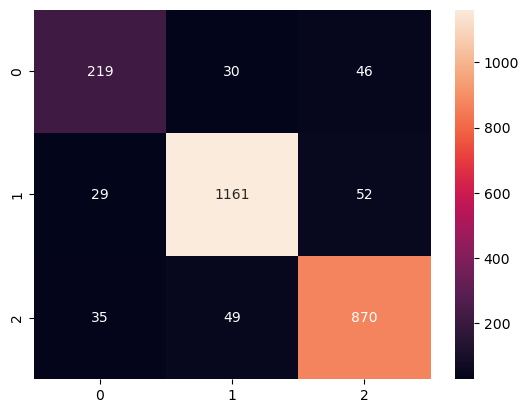

In [49]:
cnf_matrix(df)

### LIC Data Analysis

Analysis for LIC data
The accuracy is 0.7150837988826816


,precision,recall,fscore,support
0,0.59,0.65,0.62,40
1,0.84,0.79,0.81,126
2,0.18,0.23,0.20,13


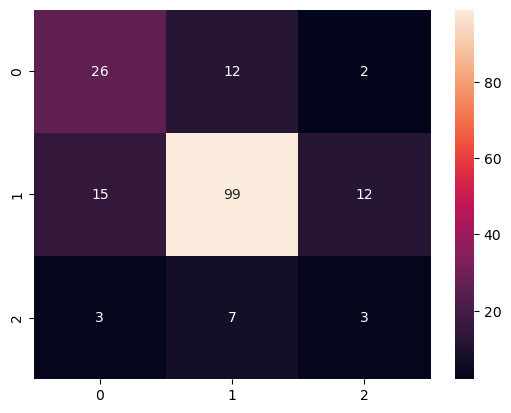

In [50]:
#collect LIC IPO data
df_LIC=df[df.IPO_label==0]
df_zomato=df[df.IPO_label==1]
print("Analysis for LIC data")
results_analysis(df_LIC)
cnf_matrix(df_LIC)

### Zomato Data

Analysis for Zomota data
The accuracy is 0.9178200692041523


,precision,recall,fscore,support
0,0.81,0.76,0.78,255
1,0.95,0.95,0.95,1116
2,0.91,0.92,0.92,941


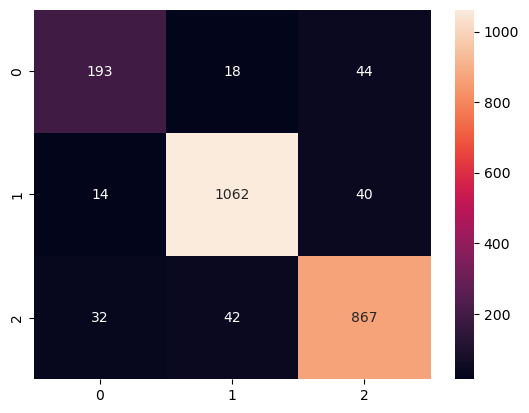

In [51]:
print("Analysis for Zomota data")
results_analysis(df_zomato)
cnf_matrix(df_zomato)

In [52]:
results_analysis(df)

The accuracy is 0.9032517061421116


,precision,recall,fscore,support
0,0.77,0.74,0.76,295
1,0.94,0.93,0.94,1242
2,0.90,0.91,0.91,954


### Appendix Information

### Word Clouds

In [53]:
# World Cloud Plotter
from wordcloud import WordCloud, STOPWORDS 
stopwords = set(STOPWORDS) 

def WordCloudForSentiments (corpus, title):
    wordcloud = WordCloud(width = 800, height = 800,background_color ='grey',
                          stopwords = stopwords,  min_font_size = 10).generate(corpus)
    
    plt.figure(figsize = (12, 12), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.rcParams.update({'font.size': 25})
    plt.axis("off") 
    plt.title('Word Cloud:  ' + title)
    plt.tight_layout(pad = 0) 
  
    plt.show()

In [54]:
# with the tweets data cleaned lets build a corpus
tweetCorpus = ''
for tweet in data.tweet:
    tweetCorpus +=  (tweet + ' ')    # adding a space to seperate tweets

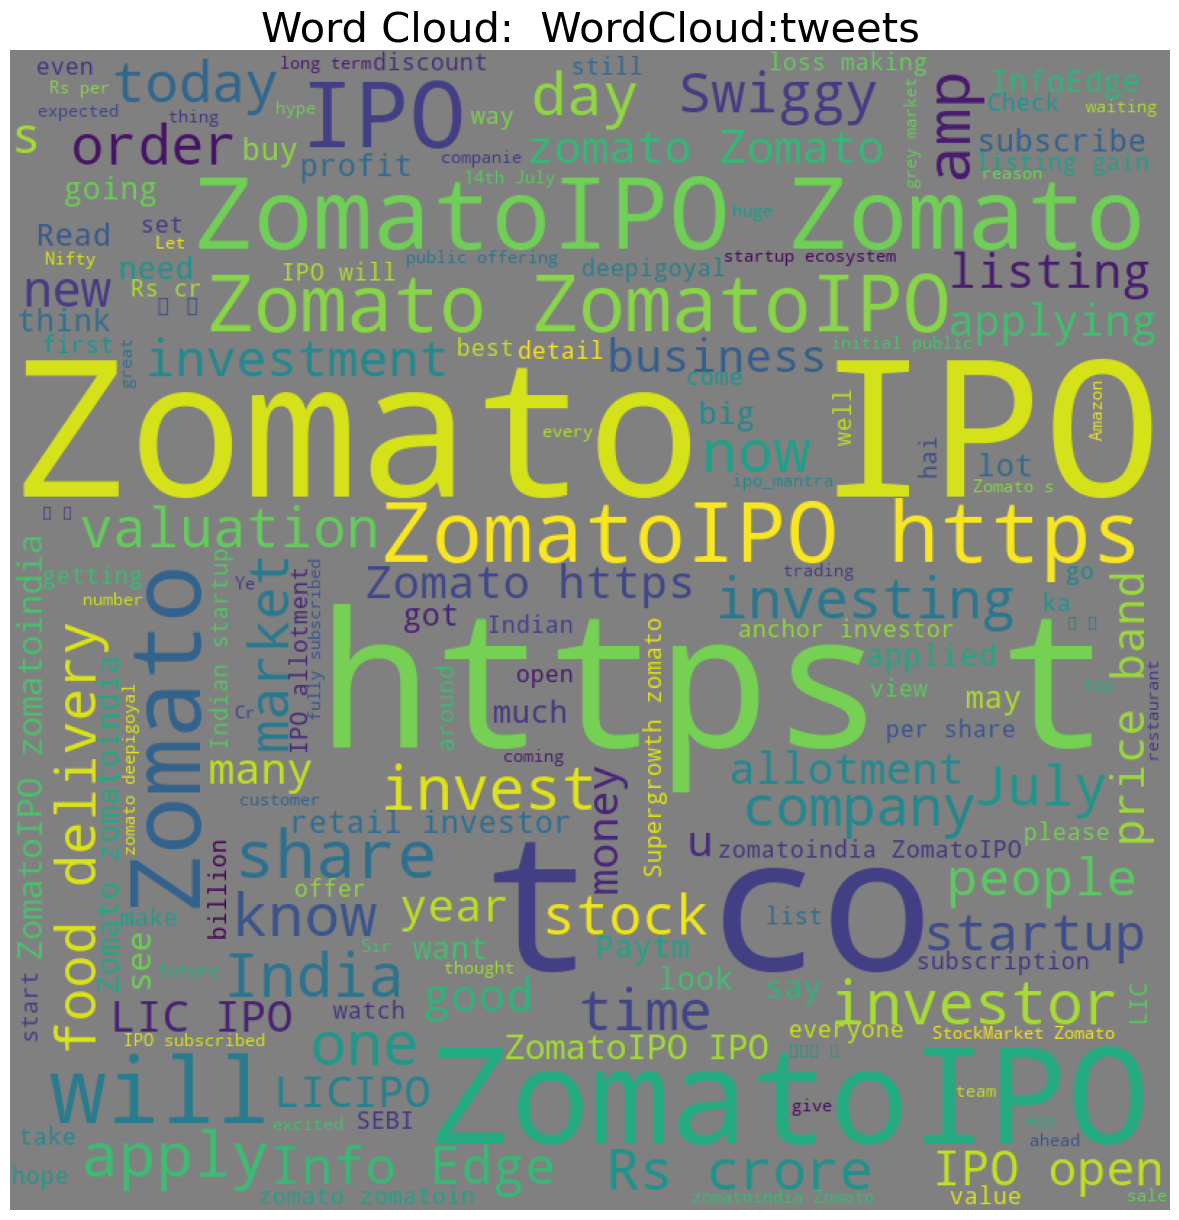

In [55]:
#Plotting tweet corpus
WordCloudForSentiments( ''.join(tweetCorpus),'WordCloud:tweets')